<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/tutorial-ML-for-GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Machine Learning for Gravitational Wave Parameter Estimation

### Stephen Green *stephen.green2@nottingham.ac.uk* and Natalia Korsakova *korsakova@apc.in2p3.fr*

---

In this tutorial we build a simple parameter estimation neural network for galactic binaries.

### Steps

1. **Build a set of training waveforms.** We use the FastGB waveforms package.
2. **Build a posterior model $q(\theta | d)$** using a neural network. We consider two cases:
    - Gaussian distribution with diagonal (learnable) covariance.
    - Normalizing flow (RealNVP).
3. **Train the model to represent the posterior**, i.e., $q(\theta|d) \to p(\theta|d)$.
    - During training, we add noise to waveforms to make simulated data.
4. **Evaluate** on test data.

## Imports

We use the [PyTorch](https://pytorch.org) ML library. Waveforms are generated using a modified version of FastGB, available from Natalia's github.

In [ ]:
# Plotting library not included in colab.
!pip install corner

In [ ]:
# Waveform generation libary based on FastGB plus noise curve for LISA.
!git clone https://github.com/NataliaKor/GBGPU.git

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

import matplotlib.pyplot as plt
import corner

import numpy as np

# Making code agnostic to CPU/GPU
def std_get_wrapper(arg):
    return arg

def cuda_get_wrapper(arg):
    return arg.get()

if torch.cuda.is_available():
   import cupy as cp
   gpu = True
   get_wrapper = cuda_get_wrapper
else:
   import numpy as cp
   gpu = False
   get_wrapper = std_get_wrapper

print(gpu)

from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise 

## Training data

### Signal model

The galactic binary waveforms that we use depend on 8 parameters $\theta$:
* Amplitude `amp`
* Initial frequency `f0` (Hz)
* Initial time derivative of frequency `fdot` (Hz/s)
* Initial phase angle of gravitational wave `phi0` (radians)
* Inclination of the orbit `iota` (radians)
* Ecliptic longitude `lam` (radians)
* Ecliptic lattitude `beta` (radians)
* Polarization angle `psi` (radians)

The FastGB package then gives us waveforms $h(\theta) = (A(\theta), E(\theta))$ where $A$, $E$ are TDI channels.

Initially, we perform inference over `amp` and `f0`, holding the remaining parameters at fixed values. Training data must be drawn from the prior, and we choose uniform `amp`, `f0` priors over some range.

### Noise

Ultimately we must train on simulated data, which also include noise,
$$
d = h(\theta) + n, \qquad n \sim p_{S_n}(n).
$$
The noise is taken to be stationary Gaussian with some power spectral density $S_n$.

Rather than creating complete simulated data sets in advance of training, **we only prepare the waveforms in advance, and we add noise realizations during training.** The reason for this is that we would like the training dataset to be as large as possible to reduce the risk of overfitting. Noise is fast to sample, so this can be done during training, and doing so effectively makes the training set much larger. Generally waveforms are slower to generate, so general practice is to re-use them in each epoch. However with a very fast waveform model (e.g., using GPU acceleration) training could be further improved by generating all data on the fly.

### Parameter sampling

Initially, we construct a dataset consisting of $10^4$ waveforms, all drawn from the prior.

In [ ]:
# Size of the training set.
num_samples = 10000

# We choose a very narrow frequency range.
f0_lower = 0.010062
f0_upper = 0.010084

# Amplitude range.
amp_lower = 1e-23
amp_upper = 1e-21

# Sample f0 and amp from a uniform prior.
f0 = cp.random.uniform(f0_lower, f0_upper, num_samples)
amp = cp.random.uniform(amp_lower, amp_upper, num_samples)

In [ ]:
# Fixed parameters
ones = cp.ones(num_samples)
fdot = 1.79e-15 * ones
lam  = 4.36 * ones
beta = 2.18 * ones
iota = 0.67 * ones
phi0 = 5.48 * ones
psi  = 0.43 * ones

In [ ]:
# Package parameters into arrays.

sampling_parameters = cp.vstack((f0, amp)).T
all_parameters = cp.vstack((amp, f0, fdot, cp.zeros(num_samples), -phi0, iota, psi, lam, beta)).T

### Waveform generation

In [ ]:
# Initialise waveform generator.
gb = GBGPU(use_gpu=gpu)

# Waveform settings
Tobs = 31536000.0  # One-year observation
dt = 15.0  # Sample rate (Nyquist is safely larger than the maximum frequency we will encounter)
df = 1./Tobs
N_points = 128

# Generate the waveforms.
gb.run_wave(*all_parameters.T, N = N_points, dt = dt, T = Tobs, oversample = 1)

The waveforms stored in `gb` are only defined over very narrow frequency support. They need to be stitched into a wider frequency band, which we define here. We choose a frequency range slightly larger than [f0_lower, f0_upper] such that full waveform can always fit in a band.

In [ ]:
f_min = 0.010059
f_max = 0.0100861

# Define the frequency grid.
num_bins = int((f_max - f_min) / df) + 1
sample_frequencies = cp.linspace(f_min, f_max, num=num_bins)

Neural networks perform best when inputs are standardized. For simulated data, we achieve this by whitening the waveforms using the predicted LISA power spectral density.

In [ ]:
noise = AnalyticNoise(sample_frequencies)
psd_A, psd_E = noise.psd(option="A"), noise.psd(option="E")

asd_A = cp.sqrt(psd_A)
asd_E = cp.sqrt(psd_E)

In [ ]:
plt.plot(get_wrapper(sample_frequencies), get_wrapper(asd_A))
plt.title('Amplitude spectral density in a band')
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude spectral density (channel A)')
plt.show()

Finally, we stitch the waveforms into the frequency grid, and at the same time apply the whitening.

In [ ]:
k_min = round(f_min/df)
k_max = round(f_max/df)
num = len(sample_frequencies)

# These indices describe how to stitch the waveform into the larger frequency grid.
i_start = (get_wrapper(gb.start_inds) - k_min).astype(cp.int32)
i_end = (get_wrapper(gb.start_inds) - k_min + gb.N).astype(cp.int32)

# PyTorch by default uses float32, and that should be sufficient for our purposes.
# Here we use complex64 since the frequency-domain strain is complex.

A_whitened = cp.empty((num_samples, num), dtype=cp.complex64)
E_whitened = cp.empty((num_samples, num), dtype=cp.complex64)

for i in range(num_samples):
    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.A[i]
    x *= cp.sqrt(4 * df) / asd_A
    A_whitened[i] = x
    
    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.E[i]
    x *= cp.sqrt(4 * df) / asd_E
    A_whitened[i] = x

In [ ]:
# Plot a sample waveform
plt.plot(get_wrapper(sample_frequencies), get_wrapper(A_whitened[0].real))
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')

plt.show()

### Package into a pytorch Dataset

The `Dataset` is a convenient class for storing and accessing pairs of parameters and associated data. It must define the following methods:

* `__len__()`: Return total number of samples in the dataset.
* `__getitem__(idx)`: Retrieve a $(\theta, d)$ pair of parameters and data. We use this method to also add (in real time) a noise realization to each simulated waveform. (Therefore repeated calls will give different noise realizations).

For now, we will only make use of the $A$ channel for simplicity, although it is straightforward to extend to include $E$.

In [ ]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set).

parameters_mean = np.mean(sampling_parameters, axis=0)
parameters_std = np.std(sampling_parameters, axis=0)

parameters_standardized = (sampling_parameters - parameters_mean) / parameters_std
parameters_standardized = parameters_standardized.astype(np.float32)

In [ ]:
# Prepare the (complex) frequency-domain data for the (real) neural network. To do so we simply concatenate the real and imaginary parts into an array of doubled length.

waveforms = cp.hstack((A_whitened.real, A_whitened.imag))

In [ ]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = signal + noise
        
        return torch.tensor(data), torch.tensor(params)

In [ ]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

In [ ]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)
plt.show()

## Gaussian posterior model

We now try to fit the posterior using a Gaussian model, i.e.,

$$
q(\theta|d) = \mathcal{N}(\mu(d), \Sigma(d)) (\theta).
$$
Here $\mu$ and $\Sigma$ are the mean and covariance matrix describing the Gaussian, and they are given as the output of a neural network, which takes as input the data $d$. Additionally, we constrain $\Sigma$ to be diagonal, so we only learn the variance in each parameter, and we do not allow for correlations between parameters in the posterior. (**Exercise:** Lift this restriction.)

### Model construction

Neural networks are constructed by subclassing `nn.Module`.

This has to implement an `__init__()` and `forward()` method.

In [ ]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers. Use a simple feedforward network.
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [ ]:
input_dim = waveforms.shape[-1]
output_dim = sampling_parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [ ]:
print(model)

### Training

In [ ]:
# Split the dataset into training and test sets. We use the test set to make sure the network properly generalizes to data that it has not seen in training, i.e., it does not overfit.

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training.

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data.

train_features, train_labels = next(iter(train_dataloader))

In [ ]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

In [ ]:
# Training and test loops.

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

In [ ]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Caution

Looking at the loss curves, we see that we have clearly overfit the data! The train loss has been going down, but the test loss has started growing. A network trained like this would be unable to interpolate to new data, and would be useless for inference. The network is essentially memorizing the training data, which it can do because the training set is too small.

#### Exercise

Go back and fix this problem. Use $10^5$ training samples instead of $10^4$. Note that when you train the network, it will take 10 times longer because we are fixing the number of epochs, not the number of iterations. Having a larger dataset typically means that we can train longer without overfitting.

### Evaluation

Make some corner plots of the posterior distribution.

In [ ]:
num_posteriors = 3
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = cp.asarray(dist.sample((10000,)))

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * cp.asarray(test_y) + parameters_mean

    # Plot
    corner.corner(get_wrapper(pred_samples), truths=get_wrapper(truth), labels=['$f_0$', 'amplitude', '$\iota$'])
    plt.show()

In [ ]:
# Joint corner plot

num_posteriors = 3
num_samples = 10000

cmap = plt.get_cmap('Set1')

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = cp.asarray(dist.sample((10000,)))

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * cp.asarray(test_y) + parameters_mean

    # Plot
    if n == 0:
        fig = corner.corner(get_wrapper(pred_samples),
                            truths=get_wrapper(truth),
                            labels=['$f_0$', 'amp'],
                            range=((f0_lower, f0_upper), (amp_lower, amp_upper)),
                            color=cmap(n), truth_color=cmap(n))
    else:
        corner.corner(get_wrapper(pred_samples), truths=get_wrapper(truth), color=cmap(n), truth_color=cmap(n), fig=fig)

plt.show()

### Further exercises

1. Train a network that samples also `iota`, so there are three parameters in total. Use the prior $p(\iota) \propto \sin(\iota)$, $0\le\iota\le\pi$. Hint: You can sample from the prior using `iota = np.arccos(1 - 2 * np.random.uniform(0, 1, num_samples))`.
2. Notice that the posterior obtained do not capture the expected correlation between `amp` and `iota`. This is because the Gaussian network is forced to have diagonal covariance matrix. Try to learn the correlation by either (a) adding the off-diagonal elements to the Gaussian network, or (b) training a flow (below).
3. Make a P--P plot.
4. Infer also the sky position parameters `lam` and `beta`. For this, it is necessary to use data from both TDI channels $A$ and $E$. Extend the `WaveformDataset` class to include these.

## Normalising flow

The diagonal Gaussian distribution is not capable of capturing features present in complex posteriors, which could include correlations  between parameters and multimodality. For this reason we turn to more powerful density estimation networks, in particular normalising flows.

A **normalising flow** is a mapping $f: u \mapsto \theta$ from a simple "base distribution" $\pi(u)$ (typically standard normal) to a more complex one $q(\theta)$. The mapping $f$ is itself parametrised using a neural network. Since the neural network is typically fast to evaluate, one can rapidly sample $\theta \sim q(\theta)$ by first sampling $u\sim \pi(u)$ and setting $\theta = f(u)$. One can also rapidly evaluate the density $q(\theta)$ provided $f$ satisfies the following properties:
1. $f$ is invertible,
2. $f$ has simple Jacobian determinant.

Indeed, by the change of variables rule, $q(\theta) = \pi(f^{-1}(\theta)) | \det J_{f^{-1}} |$, and one can easily evaluate the right hand side if (1) and (2) hold.

A normalizing flow can also describe a **conditional distribution** $q(\theta | d)$ if the flow is made to depend on $d$, in which case we denote it $f_d$. This is the case of interest for us, since we are modeling the Bayesian posterior.

There are many different types of normalising flows, and here we will implement the [RealNVP](https://arxiv.org/abs/1605.08803).

### RealNVP

This is based on the simple affine transformation, where part of the dimensions are scaled and shifted.

Let's assume that we separate the dimensions into two parts:
$x_{1:d}$ and $x_{d+1:D}$  

Half of the dimensions are kept unchanged:

$y_{1:d} = x_{1:d}$

Other half is transformed with affine transform. Lets define $t$ is a 'shift' function and $s$ is a 'scale' functions. We will parameterise them with neural networks. We apply this transformations to the first part of data:
$s(x_{1:d})$ and $t(x_{1:d})$.

Then we combine it with the data from the second half of dimensions and get:
$y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$.

The inverse transform can be written then as  
$x_{1:d} = y_{1:d}$  
$x_{d+1:D} = (y_{d+1:D}- t(y_{1:d})) \odot \exp(-s(y_{1:d}))$


To divide dimensions we use a mask:

In [ ]:
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
print(masks)

Transformations $s$ and $t$ :

In [ ]:
# Define functions s and t as simple fully connected networks:

def t_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    
    return nn.Sequential(*hidden_net_list)
 
def s_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    hidden_net_list.append(nn.Tanh())

    return nn.Sequential(*hidden_net_list) 
     


In [ ]:
input_dim = waveforms.shape[-1] + sampling_parameters.shape[-1]
output_dim = sampling_parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

Base distribution is chosen to be Gaussian Multivariate Distribution.



In [ ]:
prior = distributions.MultivariateNormal(torch.zeros(sampling_parameters.shape[-1]), torch.eye(sampling_parameters.shape[-1]))


Implementation of the flow:  
 
1.   Implement change of variable equation $q(\theta) = \pi(f^{-1}(\theta)) | \det J_{f^{-1}} |$, $f^{-1}(\theta) = g(\theta)$  
2.   Optimise KL between $\pi(f^{-1}(\theta))$ and $N(0,1)$





In [ ]:
class RealNVP_wf(nn.Module):
    def __init__(self, s_func, t_func, mask, prior):
        super(RealNVP_wf, self).__init__()
        
        self.prior = prior

        self.register_buffer('mask', mask)
        self.t = torch.nn.ModuleList([t_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([s_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        
    def g(self, z, w):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            x_wf = torch.cat([x_, w],dim=1)
            s = self.s[i](x_wf)*(1 - self.mask[i])
            t = self.t[i](x_wf)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, w):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            z_wf = torch.cat([z_, w],dim=1)
            s = self.s[i](z_wf) * (1-self.mask[i])
            t = self.t[i](z_wf) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    
    def log_prob(self, x, w):
        z, logp = self.f(x, w)
        return self.prior.log_prob(z) + logp
        


In [ ]:
flow_wf = RealNVP_wf(s_func, t_func, masks, prior)

In [ ]:
# Training and test loops

def train_loop_flow(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss

        loss = - model.log_prob(y, X)
    
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop_flow(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:

            loss = - model.log_prob(y, X)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
optimizer = torch.optim.Adam([p for p in flow_wf.parameters() if p.requires_grad==True], lr=2e-4)

In [ ]:
epochs = 10
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop_flow(train_dataloader, flow_wf, optimizer)
    train_history.append(loss)
    loss = test_loop_flow(test_dataloader, flow_wf)
    test_history.append(loss)
print("Done!")

In [ ]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
num_posteriors = 5
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Repeat same wf for a number of samples
    wf = torch.from_numpy(np.tile(test_x, (num_samples, 1))).type(torch.FloatTensor)

    # Sample from base distribution
    z = prior.sample((num_samples,1)).view(num_samples,-1)

    # Predict a posterior
    pred_samples = cp.asarray(flow_wf.g(z, wf).detach())

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * cp.asarray(test_y) + parameters_mean

    # Plot
    corner.corner(get_wrapper(pred_samples), truths=get_wrapper(truth), labels=['$f0$', '$amp$', 'iota'])
    plt.show()

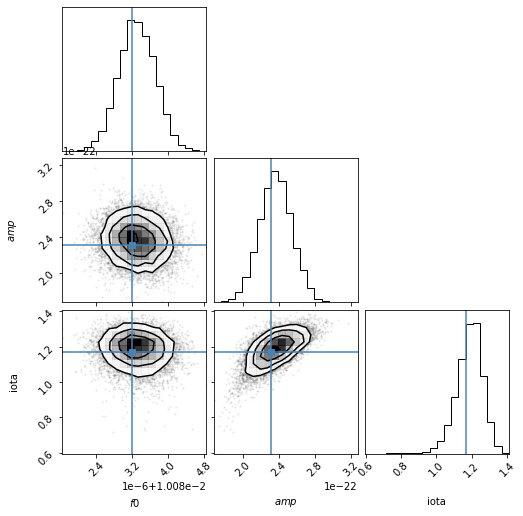

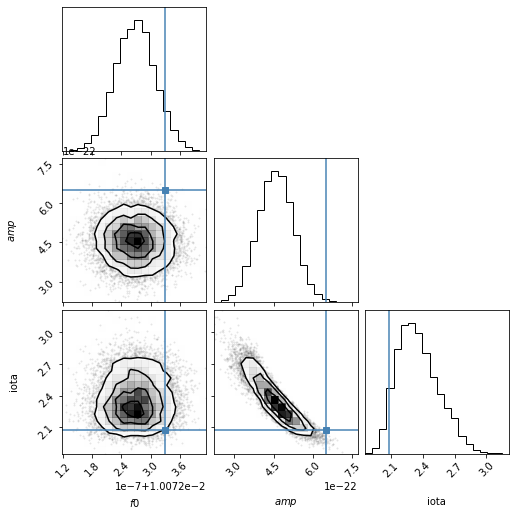

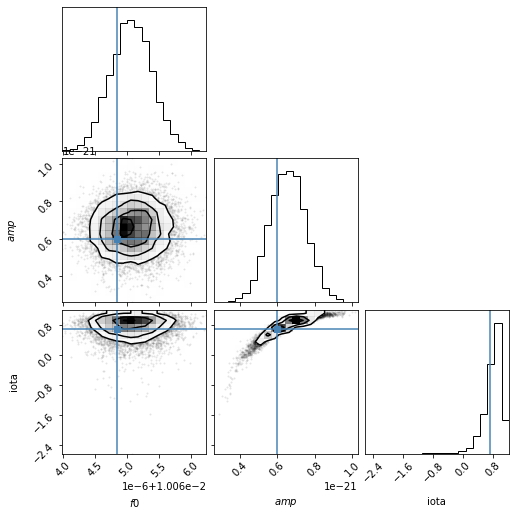

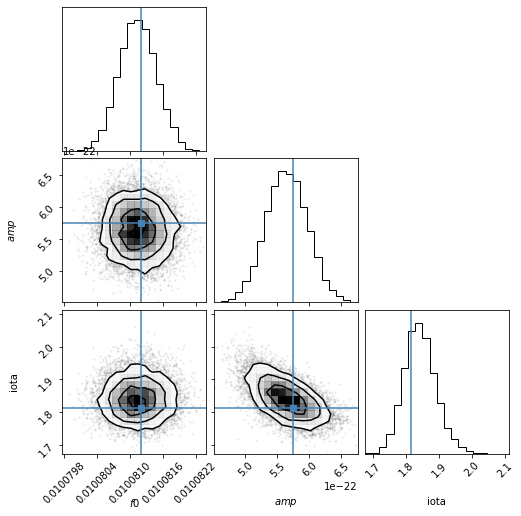

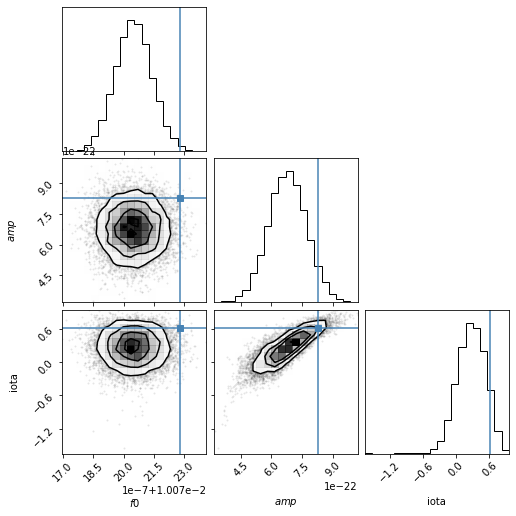

In [ ]:
num_posteriors = 5
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Repeat same wf for a number of samples
    wf = torch.from_numpy(np.tile(test_x, (num_samples, 1))).type(torch.FloatTensor)

    # Sample from base distribution
    z = prior.sample((num_samples,1)).view(num_samples,-1)

    # Predict a posterior
    pred_samples = cp.asarray(flow_wf.g(z, wf).detach())

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * cp.asarray(test_y) + parameters_mean

    # Plot
    corner.corner(get_wrapper(pred_samples), truths=get_wrapper(truth), labels=['$f0$', '$amp$', 'iota'])
    plt.show()